## Introduction 

With data from the CDC and Behavioral Risk Factor Surveillance System, this model utilizes Logistical Regression to predict the likelihood of diabetes based on independent variables identified during the data processing and analysis.

There are 32 possible variables attributing to diabetes risk classified as either demographic(sex, race, age, etc.), behavioral(physical activity levels, sleep duration, etc.), or medical variables(asthma, kidney disease history, etc.).

According to the CDC's diabetes site, common risk factors for Type I diabetes include having first relatives with Type I diabetes and age. On the other hand, factors of Type II diabetes include being overweight, age, having first relatives with Type II diabetes, and being an African American, Hispanic or Latino, American Indian, or Alaska Native person. There is no differentiation between Type I and Type II diabetes in this dataset, so all independent variables identified are risk factors contributing to increased diabetes risk overall.

## Import Python Modules and Data

In [1]:
import numpy as np 
import pandas as pd 
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None  # default='warn' remove warning for editing copy slice of main df

In [2]:
cat = pd.read_csv("/kaggle/input/cdc-diabetes-data/data_categorical.csv")
num = pd.read_csv("/kaggle/input/cdc-diabetes-data/data_numeric.csv")
ord = pd.read_csv("/kaggle/input/cdc-diabetes-data/data_ordinal.csv")

## Data Cleaning

Merging dataframes and removing duplicate columns.

In [3]:
cat = cat.drop(['DIABETE3.1', 'MARITAL.1'], axis = 1)

In [4]:
#merge ordinal and categorical datasets
df_twodata = pd.merge(cat, ord, how = 'inner', left_on = ['DIABETE3', 'PERSONID'], 
                  right_on = ['DIABETE3', 'PERSONID'])
df_twodata.head()

,PERSONID,DIABETE3,_RACE,MSCODE,FLUSHOT6,EMPLOY1,SEX,MARITAL,CVDCRHD4,HLTHCVR1,...,ASTHMA3,GENHLTH,_AGEG5YR,_BMI5CAT,CHECKUP1,INCOME2,_EDUCAG,SLEPTIM1,MENTHLTH,_SMOKER3
0,355467,3.0,2.0,NaN,2.0,1.0,1.0,6.0,2.0,7.0,...,2.0,1.0,6.0,3.0,3.0,3.0,3.0,6.0,88.0,4.0
1,117235,3.0,1.0,5.0,1.0,7.0,2.0,3.0,2.0,2.0,...,2.0,1.0,10.0,3.0,1.0,4.0,2.0,7.0,88.0,4.0
2,268614,3.0,1.0,1.0,1.0,7.0,2.0,3.0,2.0,3.0,...,2.0,2.0,12.0,2.0,1.0,3.0,2.0,8.0,2.0,4.0
3,332821,3.0,4.0,NaN,2.0,1.0,1.0,1.0,2.0,NaN,...,2.0,2.0,3.0,2.0,1.0,8.0,4.0,6.0,15.0,3.0
4,348522,3.0,1.0,NaN,1.0,1.0,2.0,1.0,2.0,1.0,...,2.0,2.0,9.0,2.0,2.0,8.0,3.0,7.0,88.0,4.0


In [5]:
#Determine which columns in numeric not part of df_twodata
different_cols = num.columns.difference(df_twodata.columns) 

In [6]:
num2 = num[different_cols] #Index slice will exclude duplicate columns

In [7]:
df = pd.merge(df_twodata, num2, how = 'inner', left_index=True, right_index=True)
#Merge completed and duplicates removed

In [8]:
df.set_index('PERSONID', inplace=True) #Set PersonID as index
df.head()

,DIABETE3,_RACE,MSCODE,FLUSHOT6,EMPLOY1,SEX,MARITAL,CVDCRHD4,HLTHCVR1,CHCKIDNY,...,CHECKUP1,INCOME2,_EDUCAG,SLEPTIM1,MENTHLTH,_SMOKER3,CHILDREN,DRVISITS,NUMADULT,WEIGHT2
PERSONID,,,,,,,,,,,,,,,,,,,,,
355467,3.0,2.0,NaN,2.0,1.0,1.0,6.0,2.0,7.0,2.0,...,3.0,3.0,3.0,6.0,88.0,4.0,2.0,6.0,NaN,180.0
117235,3.0,1.0,5.0,1.0,7.0,2.0,3.0,2.0,2.0,2.0,...,1.0,4.0,2.0,7.0,88.0,4.0,88.0,2.0,1.0,160.0
268614,3.0,1.0,1.0,1.0,7.0,2.0,3.0,2.0,3.0,2.0,...,1.0,3.0,2.0,8.0,2.0,4.0,88.0,2.0,1.0,120.0
332821,3.0,4.0,NaN,2.0,1.0,1.0,1.0,2.0,NaN,2.0,...,1.0,8.0,4.0,6.0,15.0,3.0,88.0,NaN,NaN,160.0
348522,3.0,1.0,NaN,1.0,1.0,2.0,1.0,2.0,1.0,2.0,...,2.0,8.0,3.0,7.0,88.0,4.0,88.0,1.0,NaN,129.0


### Basic Dataframe Characteristics

In [9]:
df.info

<bound method DataFrame.info of           DIABETE3  _RACE  MSCODE  FLUSHOT6  EMPLOY1  SEX  MARITAL  CVDCRHD4  \
PERSONID                                                                       
355467         3.0    2.0     NaN       2.0      1.0  1.0      6.0       2.0   
117235         3.0    1.0     5.0       1.0      7.0  2.0      3.0       2.0   
268614         3.0    1.0     1.0       1.0      7.0  2.0      3.0       2.0   
332821         3.0    4.0     NaN       2.0      1.0  1.0      1.0       2.0   
348522         3.0    1.0     NaN       1.0      1.0  2.0      1.0       2.0   
...            ...    ...     ...       ...      ...  ...      ...       ...   
447307         3.0    2.0     NaN       2.0      1.0  1.0      5.0       2.0   
401134         3.0    1.0     1.0       1.0      1.0  2.0      5.0       2.0   
227725         3.0    1.0     1.0       NaN      7.0  2.0      1.0       2.0   
394805         3.0    1.0     NaN       2.0      1.0  1.0      5.0       2.0   
168122  

In [10]:
df.size

165000

In [11]:
df.shape

(5000, 33)

In [12]:
df.describe()

,DIABETE3,_RACE,MSCODE,FLUSHOT6,EMPLOY1,SEX,MARITAL,CVDCRHD4,HLTHCVR1,CHCKIDNY,...,CHECKUP1,INCOME2,_EDUCAG,SLEPTIM1,MENTHLTH,_SMOKER3,CHILDREN,DRVISITS,NUMADULT,WEIGHT2
count,5000.000000,4997.000000,3187.000000,4762.000000,4981.000000,5000.000000,4990.000000,5000.000000,3318.000000,5000.000000,...,5000.000000,4962.000000,5000.000000,5000.000000,5000.000000,5000.000000,4988.000000,3567.000000,3240.000000,4950.000000
mean,2.764200,1.982389,2.867587,1.569929,3.924513,1.589200,2.229259,1.984800,3.897529,1.990800,...,1.588400,17.937525,2.988200,7.942400,65.437000,3.556200,65.691059,16.079619,1.798765,588.407071
std,0.715193,2.241631,1.688382,0.725393,2.856319,0.492028,1.659157,0.571519,11.832709,0.435377,...,1.256225,29.923320,1.127437,8.228574,35.469943,1.513043,37.779210,27.913442,0.794935,1910.764319
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,75.000000
25%,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,...,1.000000,5.000000,2.000000,6.000000,30.000000,3.000000,4.000000,2.000000,1.000000,145.000000
50%,3.000000,1.000000,3.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,2.000000,...,1.000000,7.000000,3.000000,7.000000,88.000000,4.000000,88.000000,4.000000,2.000000,175.000000
75%,3.000000,1.000000,5.000000,2.000000,7.000000,2.000000,3.000000,2.000000,3.000000,2.000000,...,2.000000,8.000000,4.000000,8.000000,88.000000,4.000000,88.000000,10.000000,2.000000,205.000000
max,9.000000,9.000000,5.000000,9.000000,9.000000,2.000000,9.000000,9.000000,99.000000,9.000000,...,9.000000,99.000000,9.000000,99.000000,99.000000,9.000000,99.000000,99.000000,7.000000,9999.000000


In [13]:
df.dtypes.value_counts()

float64    33
dtype: int64

Based on the dataframe characteristics above, all variables are floats, and there are null values in some columns except for in ['DIABETE3'].

### Normalize Dependent Variable

Normalizing the diabetes dependent variable will rescale the values into a range of [0, 1] ("Yes, has diabetes" = 1, "No diabetes" = 0) since a binary dependent variable will be easier for statistical and logistical analysis. Even though the outliers of the data will be lost, there are very few outliers for the diabetes variable in this dataset. Normalizing also transforms the data to be more concise as there are only two classifications for diabetes using .map(). 

In [14]:
df['DIABETE3'].value_counts() 

3.0    4251
1.0     627
4.0      76
2.0      39
9.0       5
7.0       2
Name: DIABETE3, dtype: int64

In [15]:
df['DIABETE3'] = df['DIABETE3'].map({1:1, 2:1, 3:0, 4:0}) #Classify data into two categories: "Yes, has diabetes" = 1, "No diabetes" = 0. 
#Outliers (7 & 9) are turned into null values.

In [16]:
df['DIABETE3'].isnull().sum() 

7

In [17]:
df = df.dropna(subset=['DIABETE3']) #Remove null rows because they do not contribute to dependent variable and cause nan errors for later analysis

In [18]:
df['DIABETE3'].isnull().sum() #Verify nulls removed

0

### Investigating Other Null and Infinite Data

In [19]:
count=0
for i in df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with null values', count)
print('since missing values is',round((count/len(df.index))*100),'% of the entire dataset, dropping the rows containing null values is too extreme.')

Total number of rows with null values 2975
since missing values is 60 % of the entire dataset, dropping the rows containing null values is too extreme.


In [20]:
count = np.isinf(df).values.sum()
print('Dataset contains ' + str(count) + ' infinite values.') #Not having to worry about infinite values

Dataset contains 0 infinite values.


Null values can be either removed by rows or columns at certain thresholds OR filled with an outlier(-999), median, or mean. Filling in certain values will affect the distribution and may affect model accuracy.

In [21]:
df.isnull().sum().sort_values(ascending = False)/len(df) * 100

MSCODE      36.250751
NUMADULT    35.189265
HLTHCVR1    33.647106
DRVISITS    28.680152
_BMI5CAT     6.348888
FLUSHOT6     4.766673
DECIDE       3.424795
BLIND        3.404767
USEEQUIP     3.264570
RENTHOM1     2.042860
WEIGHT2      1.001402
INCOME2      0.761065
EMPLOY1      0.380533
CHILDREN     0.240336
MARITAL      0.200280
_RACE        0.060084
CHECKUP1     0.000000
SEX          0.000000
_SMOKER3     0.000000
MENTHLTH     0.000000
SLEPTIM1     0.000000
_EDUCAG      0.000000
_TOTINDA     0.000000
ADDEPEV2     0.000000
_AGEG5YR     0.000000
GENHLTH      0.000000
ASTHMA3      0.000000
_STATE       0.000000
HLTHPLN1     0.000000
CVDCRHD4     0.000000
EXERANY2     0.000000
CHCKIDNY     0.000000
DIABETE3     0.000000
dtype: float64

Since there are up to 30% of null values for some columns, removing these columns will reduce the inaccuracies and inconsistencies in the data. In addition, the variables in these columns are perceived as not main factors contributing to diabetes risk based on known factors cited by CDC. For example, having healthcare coverage('HLTHCVR1') and being blind are not often research cited risk factors of diabetes with strong correlations. Thus, the prcess is to remove null value containing columns instead of filling-in these columns.

In [22]:
df_var = df.dropna(axis = 1) #Remove columns with any null values present

In [23]:
df_var.isnull().sum().sort_values(ascending = False)/len(df) #Verify no more null values

DIABETE3    0.0
ASTHMA3     0.0
MENTHLTH    0.0
SLEPTIM1    0.0
_EDUCAG     0.0
CHECKUP1    0.0
_AGEG5YR    0.0
GENHLTH     0.0
_STATE      0.0
SEX         0.0
HLTHPLN1    0.0
EXERANY2    0.0
ADDEPEV2    0.0
_TOTINDA    0.0
CHCKIDNY    0.0
CVDCRHD4    0.0
_SMOKER3    0.0
dtype: float64

### Selecting and Normalizing Independent Variables
Using Pearson's correlation test to determine which of the 32 independent variables has a statistically significant correlation with diabetes. 

* Null hypothesis(H0): There is not a significant linear correlation between the independent variable and dependent variable(Diabetes) in the dataset. 

* Alternative hypothesis(HA): There is a significant linear correlation between the independent variable and dependent variable(Diabetes) in the dataset. 

A p-value >= alpha(0.05) means that the null hypothesis is accepted; there is **not** a statistically significant linear correlation between the independent variable and diabetes in the dataset. 

A p-value < alpha(0.05) means that the null hypothesis is rejected; there is a statistically significant correlation between the independent variable and diabetes in the dataset. 

In [24]:
#Loop generates correlation and p-value between dependent variable diabetes and all other variables. 
indep_var = []
for column in df_var.columns[0:]:
    r, p = st.pearsonr(df_var[column], df_var['DIABETE3'])
    if p <= 0.05:
        indep_var.append(column)
        print(column, '  ', 'r:', round(r, 4), '  ', 'p:', round(p, 8))
    else:
        print(column, '  ',"Null hypothesis rejected - Not significant")

DIABETE3    r: 1.0    p: 0.0
SEX    Null hypothesis rejected - Not significant
CVDCRHD4    r: -0.0465    p: 0.0010108
CHCKIDNY    Null hypothesis rejected - Not significant
_TOTINDA    r: 0.0942    p: 0.0
ADDEPEV2    r: -0.0657    p: 3.42e-06
EXERANY2    r: 0.1008    p: 0.0
HLTHPLN1    Null hypothesis rejected - Not significant
_STATE    Null hypothesis rejected - Not significant
ASTHMA3    r: -0.0341    p: 0.01603162
GENHLTH    r: 0.2736    p: 0.0
_AGEG5YR    r: 0.1978    p: 0.0
CHECKUP1    r: -0.087    p: 0.0
_EDUCAG    r: -0.0695    p: 9e-07
SLEPTIM1    Null hypothesis rejected - Not significant
MENTHLTH    Null hypothesis rejected - Not significant
_SMOKER3    Null hypothesis rejected - Not significant


In [25]:
indep_var #List of statistically significant variables

['DIABETE3',
 'CVDCRHD4',
 '_TOTINDA',
 'ADDEPEV2',
 'EXERANY2',
 'ASTHMA3',
 'GENHLTH',
 '_AGEG5YR',
 'CHECKUP1',
 '_EDUCAG']

Although none of these variables have a high correlation magnitude above 0.30, Pearson's correlation test provided a narrower list of statistically significant independent variables in that the null hypothesis is rejected since p-value < alpha(0.05). These variables([indep_var] will be further analyzed for distributions and utilized to build a predictive model.

#### Normalize

Similar to the diabetes dependent variable, some independent variables will be normalized to bring most of the variables into the same range of [0, 1]. 

Only variables that can be reclassified into two categories: "Yes/Have" = 1, "No/Does not have" = 0 will be normalized. Codebook shows that 7 means "Don't Know" and 9 means "Refused to answer". 7 and 9 responses are often below 1% of the weighted percentage for surveyed response frequency, so they may be normalized as "No" which may introduce a small amount of inaccuracy when building a model but still is better than turning them into null values and removing more data. 

In [26]:
df_var['CVDCRHD4'] = df['CVDCRHD4'].map({1:1, 2:0,7:0,9:0}) 
df_var['CVDCRHD4'] = df['CVDCRHD4'].map({1:1, 2:0,7:0,9:0}) 
df_var['_TOTINDA'] = df['_TOTINDA'].map({1:1, 2:0,7:0,9:0})  
df_var['ADDEPEV2'] = df['ADDEPEV2'].map({1:1, 2:0,7:0,9:0}) 
df_var['EXERANY2'] = df['EXERANY2'].map({1:1, 2:0,7:0,9:0}) 
df_var['ASTHMA3'] = df['ASTHMA3'].map({1:1, 2:0,7:0,9:0}) 
df_var = df_var.astype('int') #All non-null values in df is turned into integers

## Explanatory Analysis

#### Dependent Variable

In [27]:
df['DIABETE3'].value_counts()

0.0    4327
1.0     666
Name: DIABETE3, dtype: int64

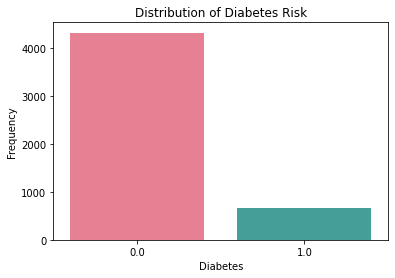

In [28]:
count_diabetes = sns.countplot(x='DIABETE3',data=df, palette = 'husl')
count_diabetes.set(xlabel='Diabetes', ylabel='Frequency')
plt.title('Distribution of Diabetes Risk')
plt.show()

4327 individuals had reported no diabetes risk and 666 individuals reported being diabetics.

#### Independent Variable

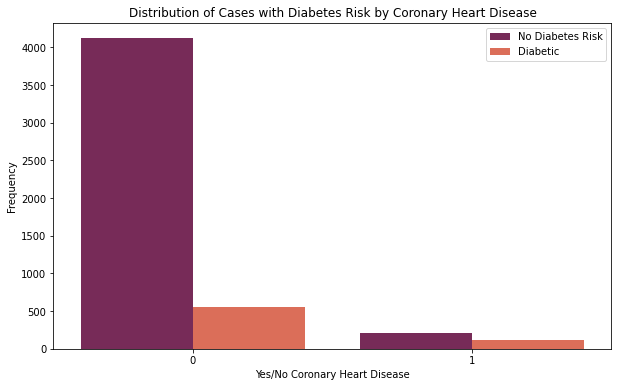

In [29]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x='CVDCRHD4', data=df_var, hue='DIABETE3', palette = 'rocket')
ax.set(xlabel='Yes/No Coronary Heart Disease', ylabel='Frequency')
plt.legend(['No Diabetes Risk','Diabetic'])
plt.title('Distribution of Cases with Diabetes Risk by Coronary Heart Disease')
plt.show()

Coronary heart disease had a statistically significant negative correlation with diabetes in the dataset. This figure describes that most cases of diabetes also do not have angina or coronary heart disease.

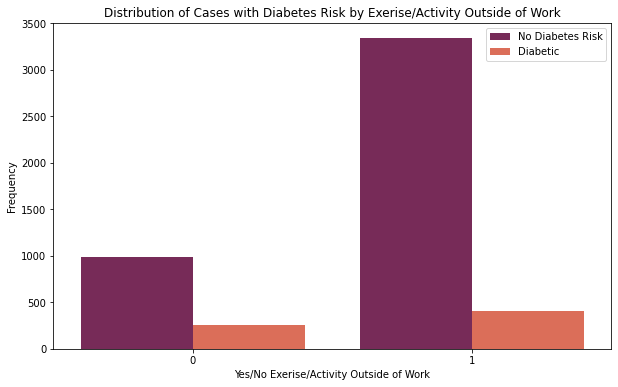

In [30]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x='_TOTINDA', data=df_var, hue='DIABETE3', palette = 'rocket')
ax.set(xlabel='Yes/No Exerise/Activity Outside of Work', ylabel='Frequency')
plt.legend(['No Diabetes Risk','Diabetic'])
plt.title('Distribution of Cases with Diabetes Risk by Exerise/Activity Outside of Work')
plt.show()

Although it is often perceived that increased physical activity reduces diabetes risk, there is a statistically significant positive correlation between physical activity outside of work and diabetes. 
The figure describes that slightly more diabetic surveyors reported having exercise/activity outside of work.

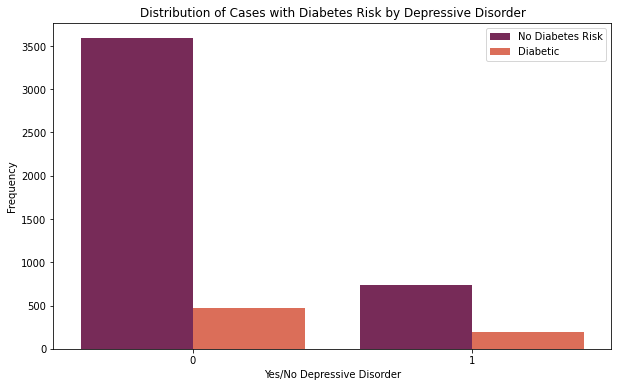

In [31]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x='ADDEPEV2', data=df_var, hue='DIABETE3', palette = 'rocket')
ax.set(xlabel='Yes/No Depressive Disorder', ylabel='Frequency')
plt.legend(['No Diabetes Risk','Diabetic'])
plt.title('Distribution of Cases with Diabetes Risk by Depressive Disorder')
plt.show()

There is a statistically significant negative correlation between having depressive disorder and diabetes. The figure shows that most cases of diabetes do not have a diagnosed depressive disorder.

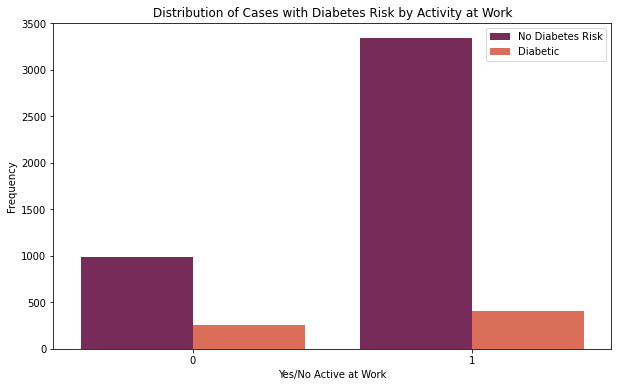

In [32]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x='EXERANY2', data=df_var, hue='DIABETE3', palette = 'rocket')
ax.set(xlabel='Yes/No Active at Work', ylabel='Frequency')
plt.legend(['No Diabetes Risk','Diabetic'])
plt.title('Distribution of Cases with Diabetes Risk by Activity at Work')
plt.show()

There is a statistically significant positive correlation between activity at work and diabetes. Interestingly, those having more activity at work have a greater rate of diabetes risk. This could be linked to food choices available at work generally, such as nearby fast food or vending machine snacks to quickly satiate hunger and then return to work.

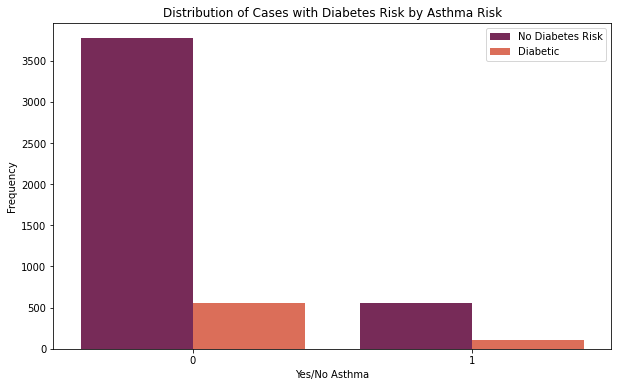

In [33]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x='ASTHMA3', data=df_var, hue='DIABETE3', palette = 'rocket')
ax.set(xlabel='Yes/No Asthma', ylabel='Frequency')
plt.legend(['No Diabetes Risk','Diabetic'])
plt.title('Distribution of Cases with Diabetes Risk by Asthma Risk')
plt.show()

There is a statistically significant negative correlation between having asthma and diabetes. The figure describes that most diabetic individuals do not have asthma. 
Asthma risks have the weakest correlation magnitude among the selected independent variables.

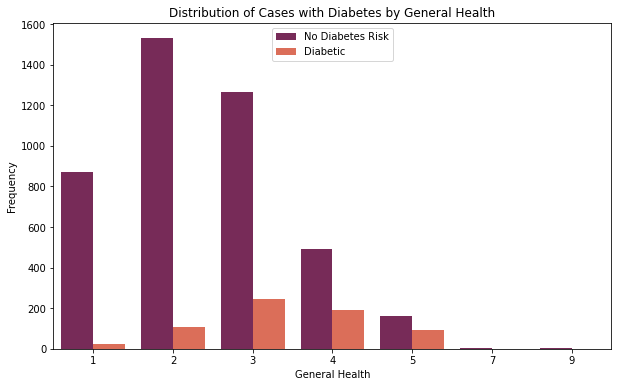

In [34]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x = df_var['GENHLTH'], hue = 'DIABETE3', data = df_var, palette = 'rocket')
ax.set(xlabel = 'General Health', ylabel = 'Frequency')
plt.legend(['No Diabetes Risk','Diabetic'])
plt.title('Distribution of Cases with Diabetes by General Health')
plt.show()

The scale for general health is Excellent(1), Very Good(2), Good(3), Fair(4), Poor(5). There is a statistically significant positive correlation between general health responses and diabetes. 
This figure describes that individuals reporting "Good"(3) and "Fair"(4) general health have the highest distribution of diabetes. 

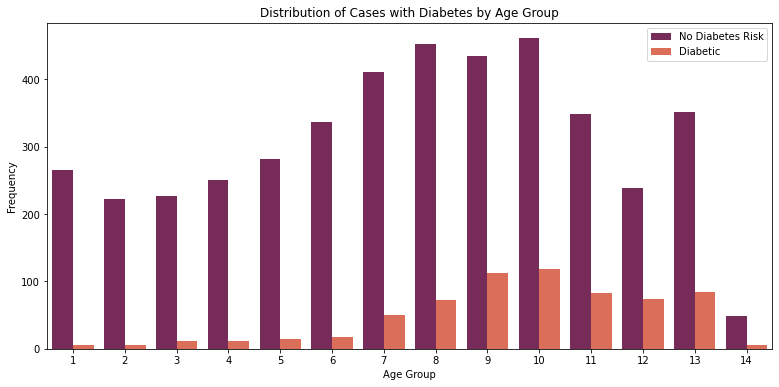

In [35]:
plt.figure(figsize = (13,6))
ax = sns.countplot(x = df_var['_AGEG5YR'], hue = 'DIABETE3', data = df_var, palette = 'rocket')
ax.set(xlabel = 'Age Group', ylabel = 'Frequency')
plt.legend(['No Diabetes Risk','Diabetic'])
plt.title('Distribution of Cases with Diabetes by Age Group')
plt.show()

There is a statistically significant positive correlation between age groups and diabetes risk. The figure shows that individuals who are 60 years old(age group 9) or older(group 9+) are more likely to be diabetic.

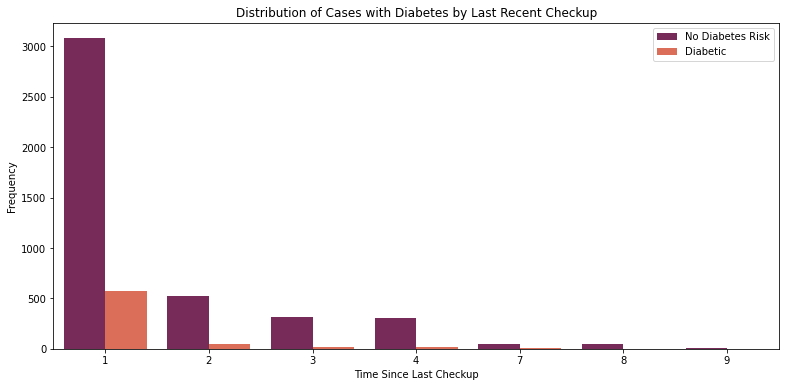

In [36]:
plt.figure(figsize = (13,6))
ax = sns.countplot(x = df_var['CHECKUP1'], hue = 'DIABETE3', data = df_var, palette = 'rocket')
ax.set(xlabel ='Time Since Last Checkup', ylabel = 'Frequency')
plt.legend(['No Diabetes Risk','Diabetic'])
plt.title('Distribution of Cases with Diabetes by Last Recent Checkup')
plt.show()

Scale: 1(Within past year), 2(Within past 2 years), 3(Within past 5 years), 4(5 or more years). There is a statistically significant negative correlation between recent health checkups and diabetes. People with the most recent checkups have a greater distribution of being diabetic; 
however, the distribution is left-skewed. This bias could be due to individuals seldom visiting their doctors in the past 2 years, therefore having a lower likelihood of receiving a diagnosis for diabetes.

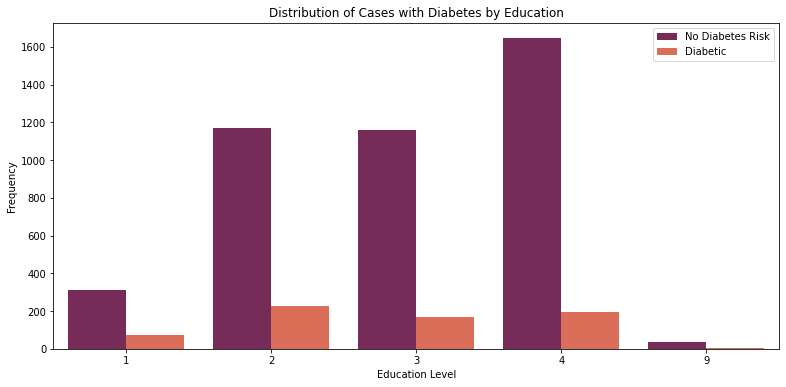

In [37]:
plt.figure(figsize = (13,6))
ax = sns.countplot(x = df_var['_EDUCAG'], hue = 'DIABETE3', data = df_var, palette = 'rocket')
ax.set(xlabel = 'Education Level', ylabel = 'Frequency')
plt.legend(['No Diabetes Risk','Diabetic'])
plt.title('Distribution of Cases with Diabetes by Education')
plt.show()

Scale: 1(Did not graduate High School), 2(Graduates High School), 3(Attended College/Technical school), 4(Graduated College/Technical school). There is a statistically significant negative correlation between education levels and diabetes risk.

# Attempting to not have train-test contamination - data leakage

Need to call test-train split before imputing. 

In [38]:
X = df.drop('DIABETE3', axis = 1)
y = df['DIABETE3']

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [40]:
from sklearn.impute import SimpleImputer

# Fill in the lines below: imputation
my_imputer = SimpleImputer()
 # Your code here
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

In [41]:
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

NameError: name 'score_dataset' is not defined

In [ ]:
#split dataset in independent and dependent variable
X = df_var[indep_var] # index slice of independent variables
y = df_var['DIABETE3'] # dependent variable

Start preprocesing - remove missing values

In [ ]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

# Logistic Regression Model 

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

Regression analysis is used to find the relationship between a dependent variable and an independent variable or series of independent variables. Since the dependent variable (Diabetes) is normalized as binary and many independent variables are both continuous and binary, logistic regression will be the best fit as a model for the prediction of diabetes risk. This logistic regression model will predict the probability of a binary event occurring ("Yes, diabetic" or "No diabetes risk"). To measure the performance of the model, a calculation metric will calculate the probability of model success from a scale of 0 to 1.0 (1.0 representing 100% accuracy). In addition, a confusion matrix will also be used to evaluate and visualize the model's performance. 

The independent variables to train the model will be the statistically significant variables from Pearson's correlation test. 

In [ ]:
from sklearn.metrics import mean_absolute_error
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    preds = logreg.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [ ]:
from sklearn.impute import SimpleImputer

	# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

	# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns


In [ ]:
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
# fit the model with data
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of the model is', metrics.accuracy_score(y_pred,y_test))

## Evaluate with Confusion Matrix

In [ ]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', y=1.1)
plt.show()

The confusion matrix shows 1498 correct predictions(1304 no Diabetes risk + 194 Diabetic) and 0 incorrect predictions. 
From the matrix, there are zero Type I (False positives) nor any Type II (False negatives) errors. Thus, proving that the model is adequate and highly accurate in predicting diabetes among individual cases for this dataset.

## Conclusions

Some identifiable risk factors for diabetes are: 
* Exercise/Activity Outside of Work
* Activity at Work
* General Health
* Age

These independent variables were proven to be significant in their correlation to diabetes as risk factors via statistical tests and analysis, thus suggesting a significant role in diabetes risk prediction. In addition, the distribution of these variables does not suggest other factors skewing the data to be biased, such as time of recent checkup contributing to a timely diabetes diagnosis.

Physical activity level is often one of the most common literature-cited factors of diabetes risk, and this model and analysis support prior research and knowledge. With the prevalence of high sugar, high fat, and high sodium levels in American processed food and culture, individuals considering their health to be fair or good might be less restrictive and less mindful of their diet and physical activity. Age is also a major factor of diabetes risk because individuals have increased Type II diabetes risk due to biological effects of increasing insulin resistance and impaired pancreatic islet function as they age according to the American Diabetes Association.

The model was predicted with 100% accuracy. However, the model could be improved with more data to further evaluate correlation magnitudes between independent variables and diabetes risk.